<a href="https://colab.research.google.com/github/prakhar17252/Domain-Adversarial-Neural-Network/blob/master/DANN_mnist_mnist-m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Setup

In [ ]:
# Import Statements
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data
from torchsummary import summary
import scipy.io

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import collections

from PIL import Image
import IPython.display as ipy

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!tar -xzf mnist_m.tar.gz

# Loading Data

In [ ]:
root_path = '/content/drive/My Drive/DL_Group/Assignments/Assignment_3/Datasets/Q3'
mnist_m_path = '/content/mnist_m/'

In [ ]:
batch_size = 200

In [ ]:
def complete_file_name(x):
  s = str(x)
  s = '0' * (8 - len(s)) + s + '.png'
  return s

In [ ]:
tr = transforms.Compose([transforms.Resize(28), transforms.ToTensor()])

In [ ]:
traindata_target_x = []
for i in range(59000):
  im_frame = tr(Image.open(mnist_m_path + 'mnist_m_train/' + complete_file_name(i)))
  traindata_target_x.append(np.array(im_frame))

In [ ]:
traindata_target_y = []
with open(mnist_m_path + 'mnist_m_train_labels.txt', 'r') as f:
  for i in range(59000):
    y = int(f.readline().split()[1])
    traindata_target_y.append(y)

In [ ]:
valdata_target_x = []
for i in range(9000):
  im_frame = tr(Image.open(mnist_m_path + 'mnist_m_test/' + complete_file_name(i)))
  valdata_target_x.append(np.array(im_frame))

In [ ]:
valdata_target_y = []
with open(mnist_m_path + 'mnist_m_test_labels.txt', 'r') as f:
  for i in range(9000):
    y = int(f.readline().split()[1])
    valdata_target_y.append(y)

In [ ]:
traindata_target_x = torch.tensor(traindata_target_x, dtype=torch.float)
traindata_target_y = torch.tensor(traindata_target_y, dtype=torch.long)

valdata_target_x = torch.tensor(valdata_target_x, dtype=torch.float)
valdata_target_y = torch.tensor(valdata_target_y, dtype=torch.long)

In [ ]:
print(traindata_target_x.shape, traindata_target_y.shape, valdata_target_x.shape, valdata_target_y.shape)

torch.Size([59000, 3, 28, 28]) torch.Size([59000]) torch.Size([9000, 3, 28, 28]) torch.Size([9000])


In [ ]:
trainset_source = torchvision.datasets.MNIST(root_path, download = True, train = True, transform = tr)
valset_source = torchvision.datasets.MNIST(root_path, download = True, train = False, transform = tr)
train_source = torch.utils.data.DataLoader(trainset_source, batch_size = batch_size, shuffle = True)
val_source = torch.utils.data.DataLoader(valset_source, batch_size = batch_size, shuffle = True)

In [ ]:
trainset_target = data.TensorDataset(traindata_target_x, traindata_target_y)
train_target = torch.utils.data.DataLoader(trainset_target, batch_size = batch_size, shuffle = True)

valset_target = data.TensorDataset(valdata_target_x, valdata_target_y)
val_target = torch.utils.data.DataLoader(valset_target, batch_size = batch_size, shuffle = True)

In [ ]:
def plot_TSNE(source, target, title, size, alpha):
  plt.scatter([i[0] for i in source], [i[1] for i in source], color='blue', label = 'source', s = size, alpha = alpha)
  plt.scatter([i[0] for i in target], [i[1] for i in target], color='red', label = 'target', s = size, alpha = alpha)
  plt.legend(loc = 'best')
  plt.title(title)
  plt.show()

# Simple NN

In [ ]:
class Source_Only(nn.Module):
  
  def __init__(self):
    super(Source_Only, self).__init__()

    self.feature_extractor = nn.Sequential()
    self.feature_extractor.add_module('conv1', nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5))
    self.feature_extractor.add_module('relu1', nn.ReLU())
    self.feature_extractor.add_module('pool1', nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.feature_extractor.add_module('conv2', nn.Conv2d(in_channels = 32, out_channels = 48, kernel_size = 5))
    self.feature_extractor.add_module('relu2', nn.ReLU())
    self.feature_extractor.add_module('pool2', nn.MaxPool2d(kernel_size = 2, stride = 2))

    self.label_predictor = nn.Sequential()
    self.label_predictor.add_module('linear1', nn.Linear(48 * 4 * 4, 100))
    self.label_predictor.add_module('relu1', nn.ReLU())
    self.label_predictor.add_module('linear2', nn.Linear(100, 100))
    self.label_predictor.add_module('relu2', nn.ReLU())
    self.label_predictor.add_module('linear3', nn.Linear(100, 10))
    self.label_predictor.add_module('softmax', nn.Softmax())

  def forward(self, x):
    out = self.feature_extractor(x)
    out = torch.flatten(out, start_dim = 1)
    out = self.label_predictor(out)
    return out

  def get_features(self, x):
    return self.feature_extractor(x)

In [ ]:
learning_rate = 0.001
num_epochs = 100

model_simple = Source_Only()
model_simple.cuda()

summary(model_simple, (3, 28, 28))

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_simple.parameters(), lr = learning_rate)

loss_train_source_1 = []
acc_train_source_1 = []
loss_val_source_1 = []
acc_val_source_1 = []
loss_val_target_1 = []
acc_val_target_1 = []

pbar = tqdm(range(num_epochs))

for epoch in pbar:
  loss_epoch = []
  correct = 0
  total = 0
  for batch_idx, (images, labels) in enumerate(train_source):
    labels = Variable(labels.long())
    images = np.array(torch.squeeze(images))
    images = torch.tensor(np.transpose(np.array([images, images, images]), (1, 0, 2, 3)))
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    outputs = model_simple(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    op = torch.argmax(outputs, dim=1)
    correct += torch.eq(labels, op).sum()
    total += images.shape[0]
    loss_epoch.append(loss.data)
  loss_train_source_1.append((sum(loss_epoch)/len(loss_epoch)).item())
  acc_train_source_1.append(correct.item() / total)

  loss_epoch = []
  correct = 0
  total = 0
  for batch_idx, (images, labels) in enumerate(val_source):
    labels = Variable(labels.long())
    images = np.array(torch.squeeze(images))
    images = torch.tensor(np.transpose(np.array([images, images, images]), (1, 0, 2, 3)))
    images = images.cuda()
    labels = labels.cuda()
    outputs = model_simple(images)
    loss = criterion(outputs, labels)

    op = torch.argmax(outputs, dim=1)
    correct += torch.eq(labels, op).sum()
    total += images.shape[0]
    loss_epoch.append(loss.data)
  loss_val_source_1.append((sum(loss_epoch)/len(loss_epoch)).item())
  acc_val_source_1.append(correct.item() / total)

  loss_epoch = []
  correct = 0
  total = 0
  for batch_idx, (images, labels) in enumerate(val_target):
    labels = Variable(labels.long())
    images = images.cuda()
    labels = labels.cuda()
    outputs = model_simple(images)
    loss = criterion(outputs, labels)

    op = torch.argmax(outputs, dim=1)
    correct += torch.eq(labels, op).sum()
    total += images.shape[0]
    loss_epoch.append(loss.data)
  loss_val_target_1.append((sum(loss_epoch)/len(loss_epoch)).item())
  acc_val_target_1.append(correct.item() / total)

  print("Epoch: %d | Train Loss: %f | Train Acc: %f | Val Source Loss: %f | Val Source Acc: %f | Val Target Loss: %f | Val Target Acc : %f" %(epoch + 1, loss_train_source_1[-1], acc_train_source_1[-1], loss_val_source_1[-1], acc_val_source_1[-1], loss_val_target_1[-1], acc_val_target_1[-1]))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 24, 24]           2,432
              ReLU-2           [-1, 32, 24, 24]               0
         MaxPool2d-3           [-1, 32, 12, 12]               0
            Conv2d-4             [-1, 48, 8, 8]          38,448
              ReLU-5             [-1, 48, 8, 8]               0
         MaxPool2d-6             [-1, 48, 4, 4]               0
            Linear-7                  [-1, 100]          76,900
              ReLU-8                  [-1, 100]               0
            Linear-9                  [-1, 100]          10,100
             ReLU-10                  [-1, 100]               0
           Linear-11                   [-1, 10]           1,010
          Softmax-12                   [-1, 10]               0
Total params: 128,890
Trainable params: 128,890
Non-trainable params: 0
-------------------------------

Epoch: 1 | Train Loss: 1.664383 | Train Acc: 0.806867 | Val Source Loss: 1.584964 | Val Source Acc: 0.877300 | Val Target Loss: 2.119812 | Val Target Acc : 0.336333
Epoch: 2 | Train Loss: 1.563084 | Train Acc: 0.899567 | Val Source Loss: 1.491260 | Val Source Acc: 0.971000 | Val Target Loss: 2.127557 | Val Target Acc : 0.326222
Epoch: 3 | Train Loss: 1.488262 | Train Acc: 0.973883 | Val Source Loss: 1.481742 | Val Source Acc: 0.979900 | Val Target Loss: 2.039114 | Val Target Acc : 0.412444
Epoch: 4 | Train Loss: 1.481919 | Train Acc: 0.979883 | Val Source Loss: 1.483764 | Val Source Acc: 0.978500 | Val Target Loss: 2.022483 | Val Target Acc : 0.423000
Epoch: 5 | Train Loss: 1.478884 | Train Acc: 0.983067 | Val Source Loss: 1.480356 | Val Source Acc: 0.981100 | Val Target Loss: 1.956243 | Val Target Acc : 0.495111
Epoch: 6 | Train Loss: 1.476000 | Train Acc: 0.985750 | Val Source Loss: 1.474275 | Val Source Acc: 0.987100 | Val Target Loss: 1.914110 | Val Target Acc : 0.541667
Epoch: 7 |

In [ ]:
model_path = '/content/drive/My Drive/DL_Group/Assignments/Assignment_3/Outputs/Q3/Saved_Model/source_only_b.pt'
torch.save(model_simple, model_path)

In [ ]:
model_path = '/content/drive/My Drive/DL_Group/Assignments/Assignment_3/Outputs/Q3/Saved_Model/source_only_b.pt'
model_simple = torch.load(model_path)

In [ ]:
source_points_simple = []
for batch_idx, (images, labels) in enumerate(val_source):
  labels = Variable(labels.long())
  images = np.array(torch.squeeze(images))
  images = torch.tensor(np.transpose(np.array([images, images, images]), (1, 0, 2, 3)))
  images = images.cuda()
  labels = labels.cuda()
  outputs = torch.flatten(model_simple.feature_extractor(images), start_dim = 1)
  tsne = TSNE(2).fit_transform(np.array(outputs.cpu().detach()))
  try:
    source_points_simple = np.concatenate((source_points_simple, tsne), axis = 0)
  except:
    source_points_simple = tsne

target_points_simple = []
for batch_idx, (images, labels) in enumerate(val_target):
  labels = Variable(labels.long())
  images = images.cuda()
  labels = labels.cuda()
  outputs = torch.flatten(model_simple.feature_extractor(images), start_dim = 1)
  tsne = TSNE(2).fit_transform(np.array(outputs.cpu().detach()))
  try:
    target_points_simple = np.concatenate((target_points_simple, tsne), axis = 0)
  except:
    target_points_simple = tsne

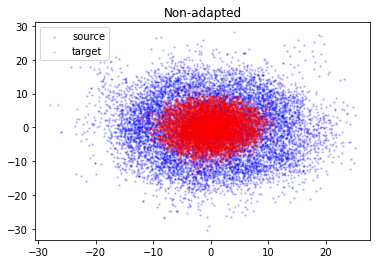

In [ ]:
plot_TSNE(source_points_simple, target_points_simple, 'Non-adapted', 2, 0.2)

# DANN

In [ ]:
from torch.autograd import Function

class ReverseLayerF(Function):
  @staticmethod
  def forward(ctx, x, alpha):
    ctx.alpha = alpha
    return x.view_as(x)

  @staticmethod
  def backward(ctx, grad_output):
    output = grad_output.neg() * ctx.alpha
    return output, None

In [ ]:
class DANN(nn.Module):

  def __init__(self):
    super(DANN, self).__init__()

    self.feature_extractor = nn.Sequential()
    self.feature_extractor.add_module('conv1', nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 5))
    self.feature_extractor.add_module('relu1', nn.ReLU())
    self.feature_extractor.add_module('pool1', nn.MaxPool2d(kernel_size = 2, stride = 2))
    self.feature_extractor.add_module('conv2', nn.Conv2d(in_channels = 32, out_channels = 48, kernel_size = 5))
    self.feature_extractor.add_module('relu2', nn.ReLU())
    self.feature_extractor.add_module('pool2', nn.MaxPool2d(kernel_size = 2, stride = 2))

    self.label_predictor = nn.Sequential()
    self.label_predictor.add_module('linear1', nn.Linear(48 * 4 * 4, 100))
    self.label_predictor.add_module('relu1', nn.ReLU())
    self.label_predictor.add_module('linear2', nn.Linear(100, 100))
    self.label_predictor.add_module('relu2', nn.ReLU())
    self.label_predictor.add_module('linear3', nn.Linear(100, 10))
    self.label_predictor.add_module('softmax', nn.Softmax())

    self.domain_classifier = nn.Sequential()
    self.domain_classifier.add_module('linear1', nn.Linear(48 * 4 * 4, 100))
    self.domain_classifier.add_module('relu1', nn.ReLU())
    self.domain_classifier.add_module('linear2', nn.Linear(100, 2))
    self.domain_classifier.add_module('sigmoid', nn.Sigmoid())

  def forward(self, x, lambda_):
    features = self.feature_extractor(x)
    features = torch.flatten(features, start_dim = 1)
    reverse_feature = ReverseLayerF.apply(features, lambda_)
    class_output = self.label_predictor(features)
    domain_output = self.domain_classifier(reverse_feature)

    return class_output, domain_output

  def get_features(self, x):
    return self.feature_extractor(x)

In [ ]:
learning_rate = 1e-3
num_epochs = 300

model = DANN()
model.cuda()

# summary(model, (3, 28, 28))

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

class_predictor_loss = nn.CrossEntropyLoss()
class_predictor_loss.cuda()
domain_classifier_loss = nn.CrossEntropyLoss()
domain_classifier_loss.cuda()

acc_train_s_class = []
acc_train_s_domain = []

acc_train_t_class = []
acc_train_t_domain = []

acc_val_s_class = []
acc_val_s_domain = []

acc_val_t_class = []
acc_val_t_domain = []

loss_domain = []
loss_class = []

pbar = tqdm(range(num_epochs))

for epoch in pbar:
  s_iter = iter(train_source)
  t_iter = iter(train_target)

  domain_source = torch.zeros(batch_size).long().cuda()
  domain_target = torch.ones(batch_size).long().cuda()

  cor_s_class = 0
  cor_s_domain = 0
  cor_t_class = 0
  cor_t_domain = 0
  tot = 0
  l_domain = 0
  l_class = 0
  times = min(len(train_source), len(train_target))
  for i in range(times):

    source_x, source_y = s_iter.next()
    target_x, target_y = t_iter.next()
    source_x = np.array(torch.squeeze(source_x))
    source_x = torch.tensor(np.transpose(np.array([source_x, source_x, source_x]), (1, 0, 2, 3)))

    source_x = source_x.cuda()
    source_y = source_y.cuda()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    p = float(i + epoch * times) / (num_epochs * times)  
    lambda_ = 2.0 / (1. + np.exp(-10 * p)) - 1

    tot += batch_size
    optimizer.zero_grad()

    class_output, domain_output = model(source_x, lambda_)
    err_source_class = class_predictor_loss(class_output, source_y)
    err_source_domain = domain_classifier_loss(domain_output, domain_source)

    l_class += err_source_class.data
    l_domain += err_source_domain.data
    cor_s_class += torch.eq(source_y, torch.argmax(class_output, dim = 1)).sum()
    cor_s_domain += torch.eq(domain_source, torch.argmax(domain_output, dim = 1)).sum()

    class_output, domain_output = model(target_x, lambda_)
    err_target_domain = domain_classifier_loss(domain_output, domain_target)

    l_domain += err_target_domain.data
    cor_t_class += torch.eq(target_y, torch.argmax(class_output, dim = 1)).sum()
    cor_t_domain += torch.eq(domain_target, torch.argmax(domain_output, dim = 1)).sum()

    loss = err_source_class + err_source_domain + err_target_domain
    loss.backward()
    optimizer.step()

  loss_domain.append(l_domain / (2 * times))
  loss_class.append(l_class / times)
  acc_train_s_class.append(cor_s_class.item() / tot)
  acc_train_s_domain.append(cor_s_domain.item() / tot)
  acc_train_t_class.append(cor_t_class.item() / tot)
  acc_train_t_domain.append(cor_t_domain.item() / tot)

  s_iter = iter(val_source)
  cor_s_class = 0
  cor_s_domain = 0
  tot = 0
  times = len(val_source)
  for i in range(times):

    source_x, source_y = s_iter.next()
    source_x = np.array(torch.squeeze(source_x))
    source_x = torch.tensor(np.transpose(np.array([source_x, source_x, source_x]), (1, 0, 2, 3)))
    source_x = source_x.cuda()
    source_y = source_y.cuda()

    p = float(i + epoch * times) / (num_epochs * times)  
    lambda_ = 2.0 / (1. + np.exp(-10 * p)) - 1

    tot += batch_size

    class_output, domain_output = model(source_x, lambda_)
    cor_s_class += torch.eq(source_y, torch.argmax(class_output, dim = 1)).sum()
    cor_s_domain += torch.eq(domain_source, torch.argmax(domain_output, dim = 1)).sum()

  acc_val_s_class.append(cor_s_class.item() / tot)
  acc_val_s_domain.append(cor_s_domain.item() / tot)
  

  t_iter = iter(val_target)
  cor_t_class = 0
  cor_t_domain = 0
  tot = 0
  times = len(val_target)
  for i in range(times):

    target_x, target_y = t_iter.next()
    target_x = target_x.cuda()
    target_y = target_y.cuda()

    p = float(i + epoch * times) / (num_epochs * times)  
    lambda_ = 2.0 / (1. + np.exp(-10 * p)) - 1

    tot += batch_size

    class_output, domain_output = model(target_x, lambda_)
    cor_t_class += torch.eq(target_y, torch.argmax(class_output, dim = 1)).sum()
    cor_t_domain += torch.eq(domain_target, torch.argmax(domain_output, dim = 1)).sum()

  acc_val_t_class.append(cor_t_class.item() / tot)
  acc_val_t_domain.append(cor_t_domain.item() / tot)

  print("Train: Epoch: %d | loss_class: %f | loss_domain: %f" %(epoch + 1, loss_class[-1], loss_domain[-1]))
  print("Train: Epoch: %d | s_class: %f | s_domain: %f | t_class: %f | t_domain: %f" %(epoch + 1, acc_train_s_class[-1], acc_train_s_domain[-1], acc_train_t_class[-1], acc_train_t_domain[-1]))
  print("Val: Epoch: %d | s_class: %f | s_domain: %f | t_class: %f | t_domain: %f" %(epoch + 1, acc_val_s_class[-1], acc_val_s_domain[-1], acc_val_t_class[-1], acc_val_t_domain[-1]))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train: Epoch: 1 | loss_class: 1.662588 | loss_domain: 0.457843
Train: Epoch: 1 | s_class: 0.810271 | s_domain: 0.956915 | t_class: 0.339424 | t_domain: 0.732068
Val: Epoch: 1 | s_class: 0.954700 | s_domain: 0.971900 | t_class: 0.440111 | t_domain: 0.863889
Train: Epoch: 2 | loss_class: 1.497144 | loss_domain: 0.413617
Train: Epoch: 2 | s_class: 0.966017 | s_domain: 0.960407 | t_class: 0.517220 | t_domain: 0.867169
Val: Epoch: 2 | s_class: 0.980300 | s_domain: 0.961400 | t_class: 0.592444 | t_domain: 0.751333
Train: Epoch: 3 | loss_class: 1.485619 | loss_domain: 0.437900
Train: Epoch: 3 | s_class: 0.977034 | s_domain: 0.916831 | t_class: 0.569525 | t_domain: 0.853610
Val: Epoch: 3 | s_class: 0.983500 | s_domain: 0.888500 | t_class: 0.564333 | t_domain: 0.861111
Train: Epoch: 4 | loss_class: 1.488328 | loss_domain: 0.561725
Train: Epoch: 4 | s_class: 0.973678 | s_domain: 0.770746 | t_class: 0.519305 | t_domain: 0.703678
Val: Epoch: 4 | s_class: 0.985100 | s_domain: 0.939600 | t_class: 0.

In [ ]:
model_path = '/content/drive/My Drive/DL_Group/Assignments/Assignment_3/Outputs/Q3/Saved_Model/dann_b.pt'
torch.save(model, model_path)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type DANN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
model_path = '/content/drive/My Drive/DL_Group/Assignments/Assignment_3/Outputs/Q3/Saved_Model/dann_b.pt'
model = torch.load(model_path)

In [ ]:
source_points_dann = []
s_iter = iter(val_source)
times = len(val_source)
for i in range(times):
  source_x, source_y = s_iter.next()
  source_x = np.array(torch.squeeze(source_x))
  source_x = torch.tensor(np.transpose(np.array([source_x, source_x, source_x]), (1, 0, 2, 3)))
  source_x = source_x.cuda()

  p = float(i + epoch * times) / (num_epochs * times)  
  lambda_ = 2.0 / (1. + np.exp(-10 * p)) - 1

  outputs = torch.flatten(model.feature_extractor(source_x), start_dim = 1)
  tsne = TSNE(2).fit_transform(np.array(outputs.cpu().detach()))
  try:
    source_points_dann = np.concatenate((source_points_dann, tsne), axis = 0)
  except:
    source_points_dann = tsne

target_points_dann = []
t_iter = iter(val_target)
times = len(val_target)
for i in range(times):
  target_x, target_y = t_iter.next()
  target_x = target_x.cuda()
  
  outputs = torch.flatten(model.feature_extractor(target_x), start_dim = 1)
  tsne = TSNE(2).fit_transform(np.array(outputs.cpu().detach()))
  try:
    target_points_dann = np.concatenate((target_points_dann, tsne), axis = 0)
  except:
    target_points_dann = tsne

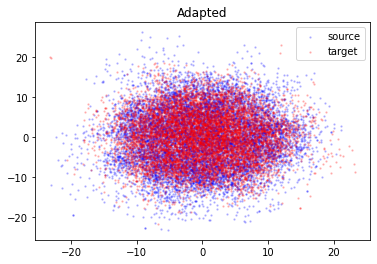

In [ ]:
plot_TSNE(source_points_dann, target_points_dann, 'Adapted', 2, 0.2)